
# Decision Tree Classifier — Adult / Census Income


**Dataset**: Adult (a.k.a. Census Income) from UCI/OpenML. Target is whether income > 50K.  




<a id="2"></a>
## 2. Datasets overview

**Adult / Census Income**  
- **Task**: Binary classification (`income`): `>50K` vs `<=50K`  
- **Size**: ~48k rows, 14 features (mix of categorical & numeric)  
- **Common fields**: `age`, `workclass`, `education`, `marital-status`, `occupation`, `relationship`, `race`, `sex`, `hours-per-week`, `native-country`, etc.
- **Notes**: Contains missing values often encoded as `"?"` in some mirrors; some features are ordinal-like.

We'll load via `sklearn.datasets.fetch_openml('adult', version=2, as_frame=True)`.


In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.datasets import fetch_openml

# Plotting defaults (matplotlib only; single figure per chart)
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

# Load Adult dataset
adult = fetch_openml('adult', version=2, as_frame=True)
df = adult.frame.copy()

In [2]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


## Detailed EDA





Display the concise summary of the DataFrame to understand the structure and data types.



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             48842 non-null  int64   
 1   workclass       46043 non-null  category
 2   fnlwgt          48842 non-null  int64   
 3   education       48842 non-null  category
 4   education-num   48842 non-null  int64   
 5   marital-status  48842 non-null  category
 6   occupation      46033 non-null  category
 7   relationship    48842 non-null  category
 8   race            48842 non-null  category
 9   sex             48842 non-null  category
 10  capital-gain    48842 non-null  int64   
 11  capital-loss    48842 non-null  int64   
 12  hours-per-week  48842 non-null  int64   
 13  native-country  47985 non-null  category
 14  class           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB


**Reasoning**:
Calculate and display descriptive statistics for numerical columns to understand their distribution and potential outliers.



In [4]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000



Calculate and display the count of unique values for each categorical column to understand the diversity of categories.



In [5]:
for col in df.select_dtypes(include='category').columns:
    print(f"Unique values in '{col}': {df[col].nunique()}")

Unique values in 'workclass': 8
Unique values in 'education': 16
Unique values in 'marital-status': 7
Unique values in 'occupation': 14
Unique values in 'relationship': 6
Unique values in 'race': 5
Unique values in 'sex': 2
Unique values in 'native-country': 41
Unique values in 'class': 2



Identify and count missing values for each column to understand the extent of missing data.



In [6]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
class                0
dtype: int64



Visualize the distribution of the target variable 'class' using a count plot to understand the class balance.



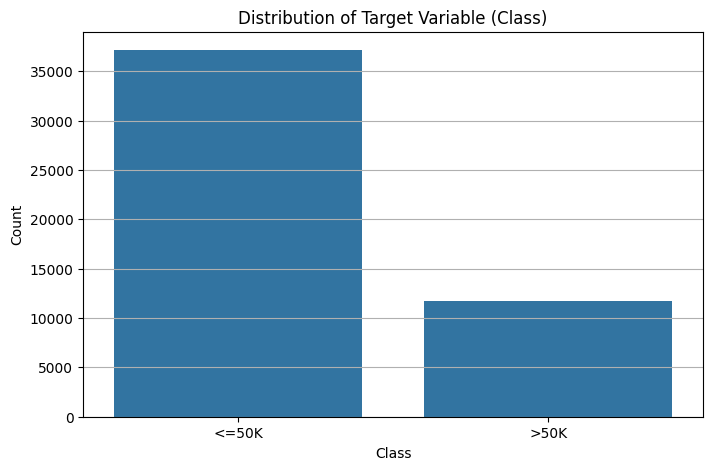

In [7]:
import seaborn as sns

sns.countplot(x='class', data=df)
plt.title('Distribution of Target Variable (Class)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


Visualize the distribution of key numerical features like 'age' and 'hours-per-week' using histograms to understand their spread.



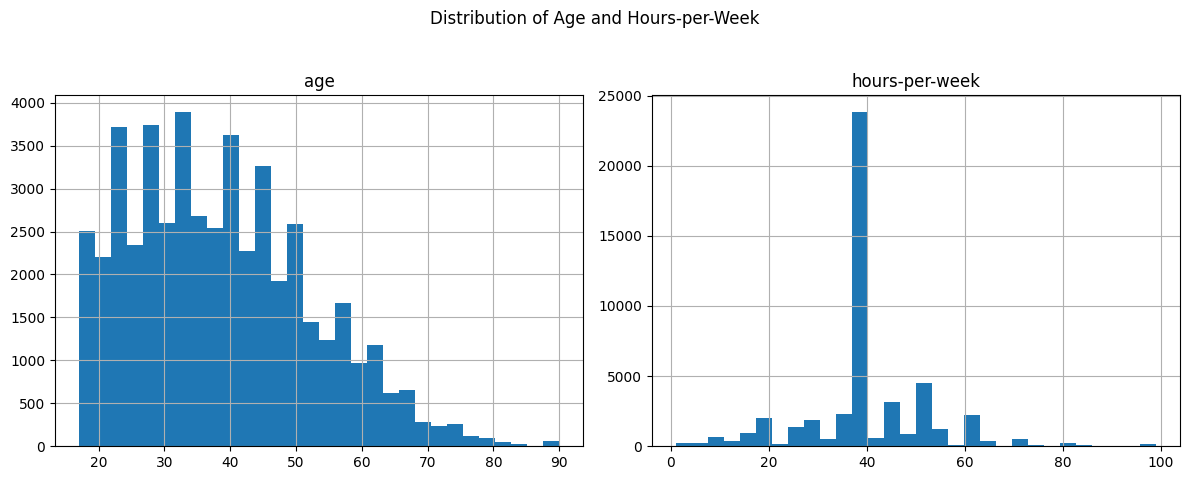

In [8]:
df[['age', 'hours-per-week']].hist(bins=30, figsize=(12, 5))
plt.suptitle('Distribution of Age and Hours-per-Week')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Visualize the relationship between key categorical features and the target variable 'class' using count plots or stacked bar plots to understand how categories relate to income level.



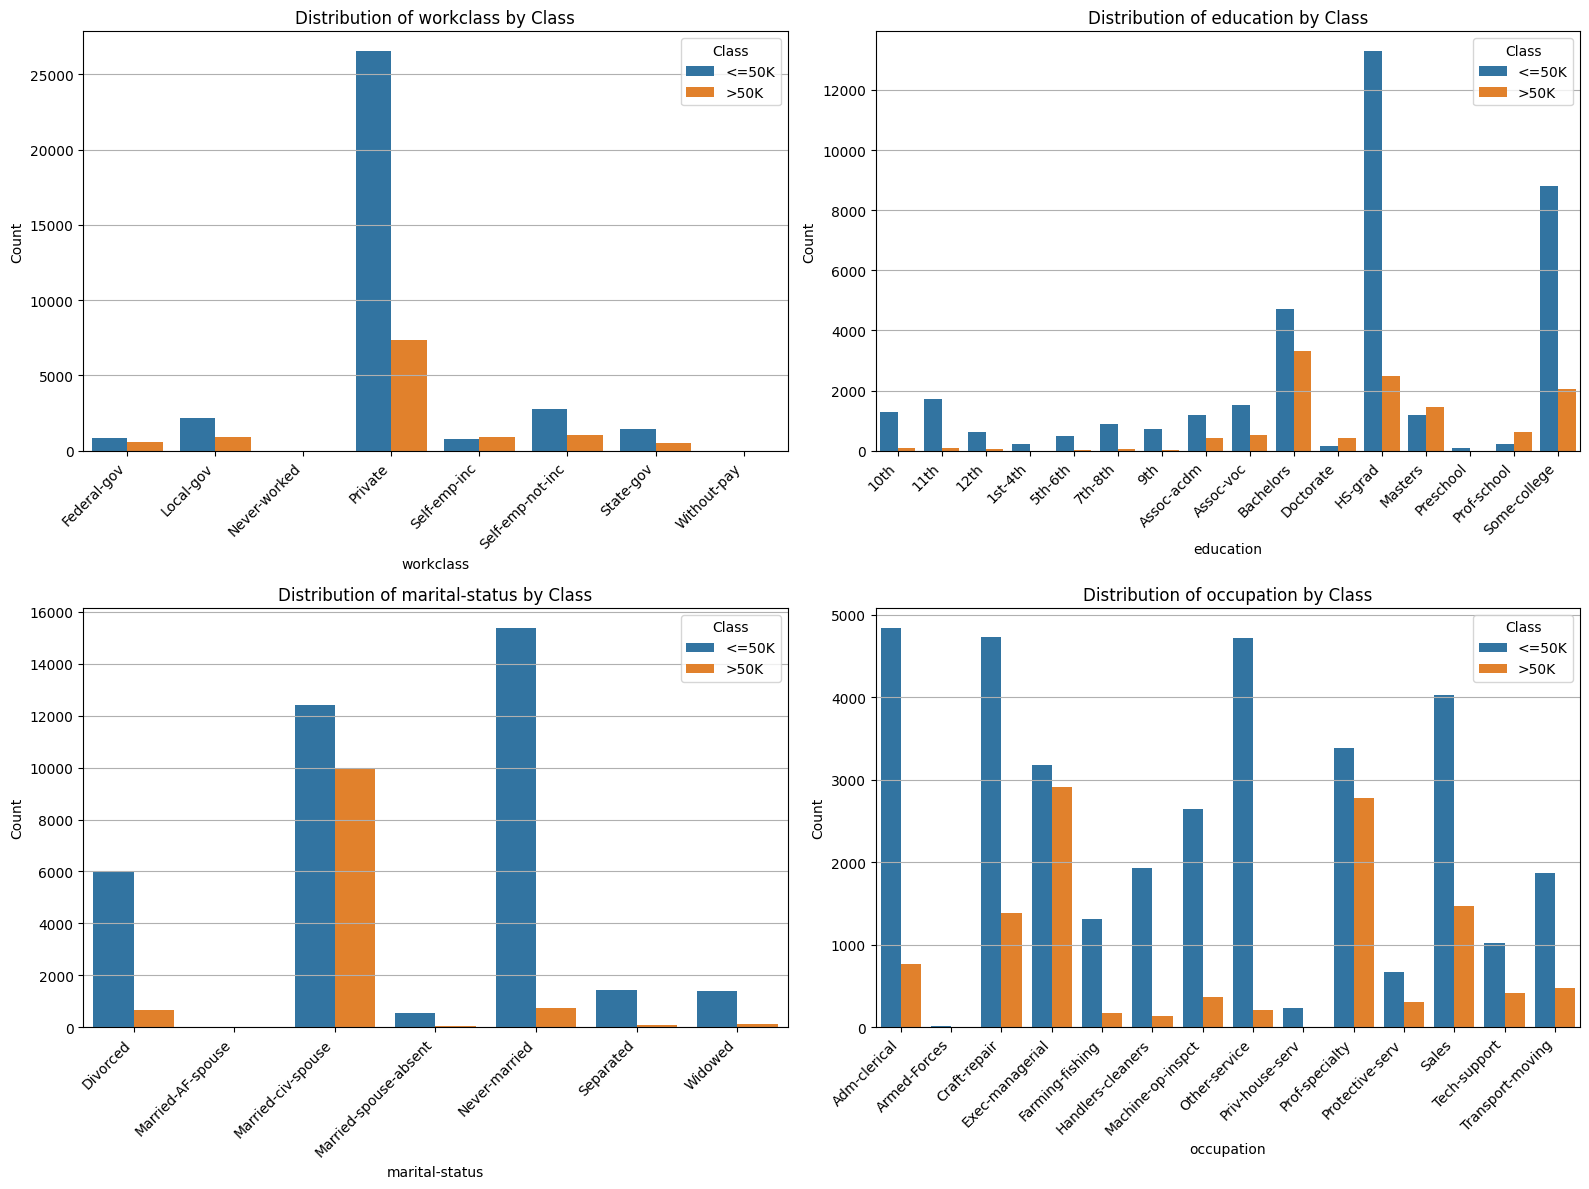

In [9]:
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, hue='class', data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Class')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].legend(title='Class')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


plt.tight_layout()
plt.show()

## Preprocessing





Identify categorical columns with missing values and impute them with the most frequent value in each column. Then identify numerical columns with missing values and impute them with the median value in each column.



In [10]:
# Identify categorical columns with missing values
categorical_cols_with_missing = df.select_dtypes(include='category').columns[df.select_dtypes(include='category').isnull().any()]

# Impute missing values in categorical columns with the mode
for col in categorical_cols_with_missing:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)

# Identify numerical columns with missing values
numerical_cols_with_missing = df.select_dtypes(include=np.number).columns[df.select_dtypes(include=np.number).isnull().any()]

# Impute missing values in numerical columns with the median
for col in numerical_cols_with_missing:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

# Verify that there are no more missing values
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
class             0
dtype: int64


Separate the target variable from the features, identify categorical and numerical features, apply one-hot encoding to the categorical features, apply StandardScaler to the numerical features, and combine the processed features into a single DataFrame.



In [11]:
# Separate target variable
X = df.drop('class', axis=1)
y = df['class']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include='category').columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create transformers for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # Handle potential unseen categories

# Create a column transformer to apply different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply the preprocessor to the features
X_processed = preprocessor.fit_transform(X)

# X_processed is now a sparse matrix (due to OneHotEncoder).
# We can keep it in this format for model training or convert to dense if needed later.
# For now, we will just confirm the shape and type.
print("Shape of processed features:", X_processed.shape)
print("Type of processed features:", type(X_processed))

Shape of processed features: (48842, 105)
Type of processed features: <class 'scipy.sparse._csr.csr_matrix'>


## Feature engineering




Create the new features as per the instructions and add them to the original DataFrame X before preprocessing.



In [12]:
# Create income_per_hour feature, handling division by zero
X['income_per_hour'] = X['capital-gain'] / X['hours-per-week'].replace(0, np.nan) # Replace 0 hours with NaN temporarily
X['income_per_hour'].fillna(0, inplace=True) # Replace resulting NaNs (from 0 hours) with 0

# Create is_married feature
X['is_married'] = X['marital-status'].apply(lambda x: 1 if 'Married' in x else 0)

# Create education_workclass_interaction feature by concatenating strings
X['education_workclass_interaction'] = X['education'].astype(str) + '_' + X['workclass'].astype(str)

# Display the first few rows with the new features
display(X.head())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income_per_hour,is_married,education_workclass_interaction
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0.0,0,11th_Private
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0.0,1,HS-grad_Private
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,0.0,1,Assoc-acdm_Local-gov
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,192.2,1,Some-college_Private
4,18,Private,103497,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,30,United-States,0.0,0,Some-college_Private



Re-apply the preprocessing steps to the updated X DataFrame which now includes the newly engineered features.



In [13]:
# Identify categorical and numerical features again after adding new features
categorical_features = X.select_dtypes(include='category').columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create transformers for numerical and categorical features
# Re-instantiate or re-use transformers as appropriate.
# Since we are applying to a modified X, fitting again is appropriate.
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a column transformer to apply different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply the preprocessor to the features
X_processed = preprocessor.fit_transform(X)

# Confirm the shape and type after re-processing
print("Shape of processed features after adding new features:", X_processed.shape)
print("Type of processed features after adding new features:", type(X_processed))

Shape of processed features after adding new features: (48842, 107)
Type of processed features after adding new features: <class 'scipy.sparse._csr.csr_matrix'>


## Cross validation



Split the data into training and testing sets, instantiate a Decision Tree Classifier, perform cross-validation, and print the scores.



In [14]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Instantiate Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.81791427 0.815611   0.81701855 0.80752496 0.80906066]
Mean cross-validation score: 0.8134258883074998


## Decision tree classifier for modelling



Instantiate and train a Decision Tree Classifier model on the training data.



In [15]:
from sklearn.tree import DecisionTreeClassifier

# Instantiate a DecisionTreeClassifier object with random_state=42
dt_model = DecisionTreeClassifier(random_state=42)

# Fit the Decision Tree Classifier model to the training data
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## Metrics for evaluation


Evaluate the trained Decision Tree Classifier model using accuracy, precision, recall, and F1-score on the test set.



In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = dt_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='>50K') # Specify the positive class
recall = recall_score(y_test, y_pred, pos_label='>50K')     # Specify the positive class
f1 = f1_score(y_test, y_pred, pos_label='>50K')             # Specify the positive class

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8215
Precision: 0.6149
Recall: 0.6380
F1-score: 0.6262
